In [4]:
from __future__ import division, print_function, unicode_literals
import numpy as np
import os
import sys
import gym
from PIL import Image, ImageDraw
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from collections import deque
import numpy as np
import Box2D
#from Box2D.b2 import (edgeShape, circleShape, fixtureDef, polygonShape, revoluteJointDef, contactListener)
 
import gym
from gym import spaces
from gym.utils import colorize, seeding, EzPickle
from PIL import Image, ImageDraw
from itertools import product


In [5]:
#Discretization
possible_actions = np.array(list(product([-1,  0,  1], [-1,  0,  1], [-1,  0,  1], [-1,  0,  1])))
env = gym.make("BipedalWalker-v2")

obs = env.reset()

In [6]:
#Policy Network:
#Specify the network architecture
#Build the neural network
#Select a random action based on the estimated probabilities
#Define the training scheme 
#Run the policy for 1000 steps before training.


tf.reset_default_graph()

# 1. Specify the network architecture
n_inputs = env.observation_space.shape[0]  # == 24
n_hidden = 10
n_outputs = len(possible_actions) # == 625
initializer = tf.variance_scaling_initializer()

# 2. Build the neural network
X = tf.placeholder(tf.float32, shape=[None, n_inputs])

hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.selu, kernel_initializer=initializer)
logits = tf.layers.dense(hidden, n_outputs, kernel_initializer=initializer)
outputs = tf.nn.softmax(logits)

# 3. Select a random action based on the estimated probabilities
action_index = tf.squeeze(tf.multinomial(logits, num_samples=1), axis=-1)


# 4. Training
y = tf.one_hot(action_index, depth=len(possible_actions))
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=logits)
optimizer = tf.train.AdamOptimizer(0.01)
grads_and_vars = optimizer.compute_gradients(cross_entropy)
gradients = [grad for grad, variable in grads_and_vars]
gradient_placeholders = []
grads_and_vars_feed = []
for grad, variable in grads_and_vars:
    g_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
    gradient_placeholders.append(g_placeholder)
    grads_and_vars_feed.append((g_placeholder, variable))
training_op = optimizer.apply_gradients(grads_and_vars_feed)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.random.categorical instead.


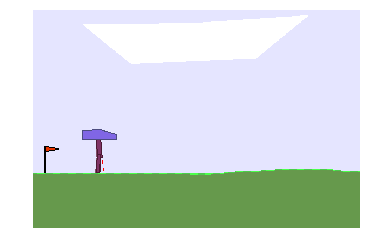

In [7]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch

env = gym.make("BipedalWalker-v2")
fs = []
with tf.Session() as sess:
    
    init.run()
    obs = env.reset()
    for step in range(1000):
        
        fs.append(env.render(mode="rgb_array"))
        action = possible_actions[action_index.eval(feed_dict={X: obs.reshape(1, n_inputs)})]
        obs, reward, done, info = env.step(action[0])
        if done:
            break
env.close()

plt.close() 
fig = plt.figure()
patch = plt.imshow(fs[0])
plt.axis('off')
video=animation.FuncAnimation(fig, update_scene, fargs=(fs, patch), frames=len(fs), repeat=False, interval=50)
plt.show()




In [96]:
n_games_per_update = 10
n_max_steps = 1000
n_iterations = 1000

#n_max_steps = 10
#n_iterations = 10
save_iterations = 10
discount_rate = 0.95

def d_rewards(rewards, discount_rate):
    discounted_r = np.zeros(len(rewards))
    cumulative_rewards = 0
    for step in reversed(range(len(rewards))):
        cumulative_rewards = rewards[step] + cumulative_rewards * discount_rate
        discounted_r[step] = cumulative_rewards
    return discounted_r

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        print("\rIteration: {}/{}".format(iteration + 1, n_iterations), end="")
        all_rewards = []
        all_gradients = []
        for game in range(n_games_per_update):
            current_rewards = []
            current_gradients = []
            obs = env.reset()
            for step in range(n_max_steps):
                action_index_val, gradients_val = sess.run([action_index, gradients], feed_dict={X: obs.reshape(1, n_inputs)})
                action = possible_actions[action_index_val]
                obs, reward, done, info = env.step(action[0])
                current_rewards.append(reward)
                current_gradients.append(gradients_val)
                if done:
                    break
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)

    
        all_discounted_rewards = [d_rewards(rewards, discount_rate) for rewards in all_rewards]
        flat_rewards = np.concatenate(all_discounted_rewards)
        r_mean = flat_rewards.mean()
        r_std = flat_rewards.std()
        all_rewards=[(discounted_rewards - r_mean)/r_std for discounted_rewards in all_discounted_rewards]

        feed_dict = {}
        for var_index, gradient_placeholder in enumerate(gradient_placeholders):
            mean_gradients = np.mean([reward * all_gradients[game_index][step][var_index]
                                      for game_index, rewards in enumerate(all_rewards)
                                          for step, reward in enumerate(rewards)], axis=0)
            feed_dict[gradient_placeholder] = mean_gradients
        sess.run(training_op, feed_dict=feed_dict)
        if iteration % save_iterations == 0:
            saver.save(sess, "./walker_pg.ckpt")

Iteration: 1000/1000

INFO:tensorflow:Restoring parameters from ./walker_pg.ckpt


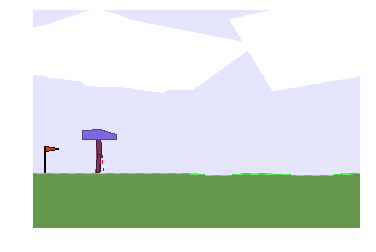

In [97]:
env = gym.make("BipedalWalker-v2")
fs = []
with tf.Session() as sess:
        
    saver.restore(sess, "./walker_pg.ckpt")
    obs = env.reset()
    for step in range(1000):
        
        fs.append(env.render(mode="rgb_array"))
        
        action = possible_actions[action_index.eval(feed_dict={X: obs.reshape(1, n_inputs)})]
        obs, reward, done, info = env.step(action[0])
        if done:
            break
env.close()

plt.close() 
fig = plt.figure()
patch = plt.imshow(fs[0])
plt.axis('off')
video=animation.FuncAnimation(fig, update_scene, fargs=(fs, patch), frames=len(fs), repeat=False, interval=50)
plt.show()